<a href="https://colab.research.google.com/github/mirnak88/Bexel/blob/main/BEXEL_carret_mirna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikacija elemenata BIM modela po kategorijama (PyCaret)




Problem koji se postavlja je klasifikacija elemenata u sklopu BIM modela po kategorijama. Postoji više različitih kategorija u koje se elementi u sklopu BIM modela mogu grupisati, zbog čega se problem može svrstati u grupu problema više-klasne klasifikacije. Više-klasna klasifikacija je tehnika nadgledanog mašinskog učenja koja ima za zadatak klasifikovanje podatka u jednu o tri ili više klasa. (Klasifikacija u jednu od sve klase naziva se binarna klasifikacija). \\

U prethodnom radnjama izvršena je analiza raspoloživih podataka i obeležija. Kao rezultat uočeno je nebalansiranost podataka po klasama, kao i to da nije uočena veća korelaciona zavisnost između ulaznih obeležija i ciljnog, odnosno izlaznog obeležija. 

U nastavku, biće dati rezultati analize modelovanja raspoloživih podataka različim matematičkim modelima iz oblasti mašinskog učenja namenjeni za višeklasnu klasifikaciju. \\

Postupak je obuhvatao sledeće korake:

*   Učitavanje, predprocesiranje podataka, normalizaciju i balansiranje
*   Odabir optimalnog modela i konfiguraciju njegovih parametara
*   Obučavanje modela
*   Testiranje modela na test skupu podataka





##Učitavanje, predprocesiranje podataka, normalizaciju i balansiranje

Za potrebe procesa analize podataka korištena je `pycaret` Python biblioteka, pa je njeno učitavanje kao i učitivanje drugih dodatnih biblioteka kao što su biblioteka `pandas` za učitavanje i analizu, te biblioteke `matplotlib` i `seaborn` za vizualizaciju podataka prvi korak u analizi. 

In [ ]:
!pip install pycaret

In [ ]:

!pip install --upgrade jinja2

In [ ]:
import pathlib
from pathlib import PosixPath, Path
from google.colab import drive
import numpy as np
import pandas as pd
import sklearn as sk
import pycaret
import jinja2

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")
sns.set(rc={'figure.figsize':(15, 10)})

Ugledni primer podataka za analizu se čuva "u oblaku" u `.csv` formatu. Ovaj format je univerzalan, te omogućava laku razmenu podataka između različitih sistema, softvera i biblioteka. Učitani skup podataka sadrži XX onosa i XX obeležija.

---



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
root_dir = PosixPath("/content/gdrive/My Drive/Colab Notebooks")
base_dir = root_dir / "BEXEL"
data_dir = base_dir / "data"
print(data_dir)
list(data_dir.iterdir())



In [ ]:
data_file = data_dir / "Model01_v2.csv"#
fpath = data_dir / "Model01.csv"
all_data = pd.read_csv(str(data_file), header=[3])

###Selekcija podataka

U procesu analiye podataka, u prethodnom izveštaju, naglašen je veliki disbalans i nebalansiranost u broju uzoraka po klasama, a posebno se ističe klasa *SITE* gde je bio prisutan samo jedan uzorak koji je pripadao toj klasi, zbog ;ega je bilo neophodno isključiti tu kategoriju iz dalje analize. Kao rezultat prethodne analize, za ulazna obeležija odabrana su sledeća:

1.  "Bounding Box Height",
2.  "Bounding Box Width", 
3.  "Bounding Box Length", 
4.  "Calculated Surface Area", 
5.  "Calculated Volume"

koja će se u nastavku analize zbog kompaktnosti obeležavati skraćenicama: *h, w, l, s, v*. Izlazno obeležije "Target Category" označavaće se skraćenicom *label*



In [ ]:
data = all_data[all_data["Target Category"] != "SITE"]
data = data[["Target Category", "Bounding Box Height", "Bounding Box Width", "Bounding Box Length", "Calculated Surface Area", "Calculated Volume"]]
data.rename(columns = {"Target Category":"label", "Bounding Box Height":"h", "Bounding Box Width":"w", "Bounding Box Length":"l", "Calculated Surface Area":"s", "Calculated Volume":"v"}, inplace = True)
data.head()

In [ ]:
columns = ["h", "w", "l", "s", "v"]
X = data[columns]
y = data["label"]

### Podela podataka na obučavajući i test skup

U nastavku je izvšrena podela raspoloživog skupa podataka  koji će se koristiti za modelovanje, i  skup podataka kojim će se proveriti valjanost  dobijenog modela i koje model "nije video" pri njegovom formiranju. Podaci za modelovanje će biti podeljeni na obučavajući trening i test skup, a više o tome u nastavku.

Podela podataka na podatke za modelovanje i grupu podataka koja neće biti korištena pri modelovanju vrši se pomoću funkcije `şample()` koja kao povratnu vrednost vraća nasumično izabrane podatke iz ukupnog skupa podataka. Broj nasumično izabranih podataka određen je ulaznim parametrom `frac`. U nastavku će biti čuvano 90% podataka za modelovanje i 10% za dalju proveru validnosti.

In [ ]:
train_data = data.sample(frac=0.80, random_state=42)
test_data = data.drop(train_data.index)

In [ ]:
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(train_data.shape))
print('Unseen Data For Predictions: ' + str(test_data.shape))

Data for Modeling: (13218, 6)
Unseen Data For Predictions: (3304, 6)


### Predprocesiranje podataka

Predprocesiranje podataka će biti urađeno uz primenu  funkcije `setup()` u sklopu biblioteke `pycaret`. Funkcija `setup()`  ima veliku broj ulaznih parametara koji omogućavaju podešavanje različitih parametara i tehnika neophodnih za predprocesiranje podataka. U sklopu ove analize korištene su sledeće tehnike:


*   Normalizacija, koja skalira sva obeležija u istom intervalu pri čemu je koištena funkcije `minmax` (detaljnije je objašnjeno u prethdnom kvartalnom izveštaju). 
*  Podela trening podataka na obučavajući i na validacioni skup. Obučavajući skup je obuhvatao 80% ukupnog skupa podataka.
*  Balansiranje, čija je namena uravnoteživanje podataka po klasama (kategorijama). Za to je korištena  `imblearn` biblioteka.


Pre nego što se izvršili balansiranja biće proverena balansiranost skupa podataka, odnosno da li su izlazne klase u skupu za obuku podjednako zastupljene. Koristiće se funkcija `value_counts()` za računanje broja uzoraka u svakoj izlaznoj klasi. 



In [ ]:
train_data['label'].value_counts()

ROAD           8284
SLAB           1554
COVERING        926
PLANTING        925
HARDSCAPE       556
MASS (CUT)      442
MASS (FILL)     302
CONDUIT         229
Name: label, dtype: int64

Izlazne klase nisu balansirane,pa je neophodno balansiranje.\

Funkcija `setup() ` pozvana sa sledećim ulaznim parametrima

*   `normalize = True` i `normalize_method='minmax'` da bi se podesile parametri za normalizaciju obeležija

*   `train_size = 0.8` da bi se izvršila podela na obuku/validaciju

*   `fix_imbalance = True` i `fix_imbalance_method=RandomOverSampler()`da bi se specificirao da je potrebno balansiranje podataka i na koji način je potrebno da se izvrši

Dodatni parametri:

*   `session_id=123` koristi se za ponovljivost eksperimenta

*   `data = data` podaci za obuku modela

*   `target = 'label'` specificiranje obeležija izlaza







In [ ]:
from pycaret.classification import *
from imblearn.over_sampling import RandomOverSampler

In [ ]:


exp1 = setup(data = train_data, target = 'label', normalize = True, normalize_method='minmax', train_size = 0.8,fix_imbalance = True, fix_imbalance_method=RandomOverSampler(), session_id=123)
#exp1 = setup(data = train_data, target = 'label', session_id=123, fix_imbalance=True) 

,Description,Value
0,session_id,123
1,Target,label
2,Target Type,Multiclass
3,Label Encoded,"CONDUIT: 0, COVERING: 1, HARDSCAPE: 2, MASS (C..."
4,Original Data,"(13218, 6)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


## Odabir optimalnog modela i konfiguraciju njegovih parametara

Izbor modela će biti urađen na dva načina:

*   Izborom specifičnog modela, optimizacijom njegove konfiguracije
*   Primenom `AutoML` biblioteke koja pronalazi najbolji model za modelovanje prosle]enih podataka



In [ ]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9590,0.9972,0.8712,0.9584,0.9580,0.9281,0.9284,2.186
rf,Random Forest Classifier,0.9545,0.9964,0.8713,0.9545,0.9541,0.9209,0.9210,3.437
lightgbm,Light Gradient Boosting Machine,0.9538,0.9960,0.8775,0.9545,0.9539,0.9202,0.9203,3.202
dt,Decision Tree Classifier,0.9349,0.9505,0.8348,0.9353,0.9347,0.8873,0.8874,0.108
gbc,Gradient Boosting Classifier,0.9085,0.9886,0.8596,0.9190,0.9113,0.8483,0.8509,36.419
knn,K Neighbors Classifier,0.8919,0.9511,0.8156,0.9028,0.8952,0.8206,0.8229,0.194
qda,Quadratic Discriminant Analysis,0.5278,0.8967,0.5607,0.7499,0.5667,0.3788,0.4354,0.049
lr,Logistic Regression,0.4582,0.8377,0.4716,0.6990,0.4992,0.2824,0.3271,6.902
lda,Linear Discriminant Analysis,0.4558,0.8410,0.4633,0.6952,0.5066,0.2790,0.3125,0.076
nb,Naive Bayes,0.4416,0.8408,0.4369,0.7005,0.4924,0.2728,0.3132,0.045


In [ ]:
best

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

Za najbolji model dobijen je model slučajne šume (*Extremely Randomized Trees Classifier(Extra Trees Classifier))* . Za dalje podešavanje parametara i konfiguracije modela koristi se funkcija `tune_model()`. Ovoj funkciji nije potrebno dodatno prosleđivati podatke, jer su oni uklju;eni kroz funkciju `setup()`. Ova funkcija zasniva se na unakrsnoj validaciji. Kod unakrsne validacije početni skup podataka (sa izuzetkom skupa za testiranje) deli na $k$ delova, koji se nazivaju slojevima (*engl. k-fold cross-validation*). Validacija se sprovodi u $k$ prolaya. U prolayu $i$ model se validira na $i$-tom sloju a obučava na svim ostalim zajedno. Finalni rezultati validacije se dobijaju uprosečavanjem rezultata na pojedinačnim slojevima. Ovde će se vršiti validacija na 10 slojeva.

In [ ]:
et_model = create_model("et")
tuned_et_model = tune_model(et_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6767,0.9351,0.7389,0.8079,0.7058,0.5365,0.5672
1,0.6777,0.9344,0.7098,0.7945,0.7022,0.5332,0.5605
2,0.6078,0.9328,0.6202,0.7754,0.6457,0.4519,0.4870
3,0.6919,0.9348,0.7124,0.7963,0.7134,0.5503,0.5756
4,0.6651,0.9306,0.6959,0.7934,0.6924,0.5189,0.5485
5,0.6878,0.9294,0.6823,0.7932,0.7089,0.5411,0.5657
6,0.6613,0.9323,0.6547,0.7913,0.6895,0.5130,0.5424
7,0.7228,0.9416,0.7022,0.8133,0.7422,0.5852,0.6064
8,0.6518,0.9264,0.6673,0.7866,0.6818,0.5035,0.5338



Uz pomoć funkcije `plot_model()`, posmatraćemo metriku primenjenog modela.

Matrica konfuzije je tabelarni prikaz podataka ispravno i pogrešno klasifikovanih
objekata na osnovu kojih se mogu vršiti ocene modela klasifikacije. Svako od polja $𝑓_{𝑖𝑗}$ označava
broj objekata klase $𝑖$ koji su klasifikovani kao objekti klase $𝑗$. Elemnti na glavnoj dijegonali su tačno klasifikovani.

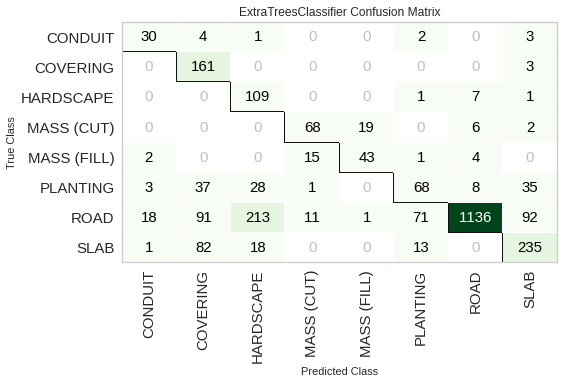

In [ ]:
plot_model(tuned_et_model, plot = 'confusion_matrix')

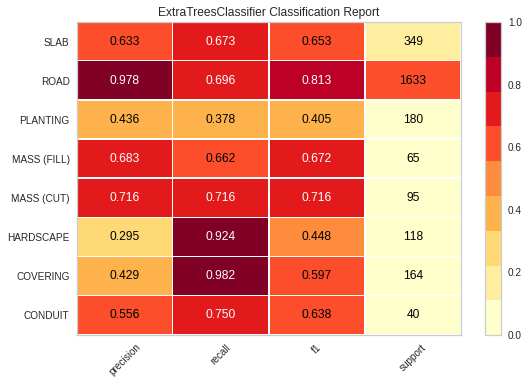

In [ ]:
plot_model(tuned_et_model, plot = 'class_report')

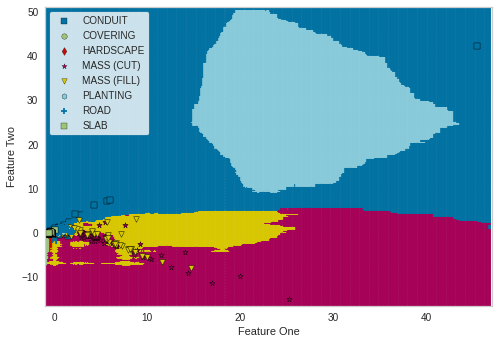

In [ ]:
plot_model(tuned_et_model, plot='boundary')

## Testiranje modela na test skupu podataka
Jednom kada je model obučen, može biti testiran nad test skupom podataka. Performanse finaliziranog modela se mogu proveriti, prvo, ponovnim pozivanjem funkcije `predict_model()`.

In [ ]:
final = finalize_model(tuned_et_model)
predict_model(tuned_et_model);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.6997,0.9391,0.7224,0.8083,0.7249,0.5642,0.5882


I na kraju, testiranje performansim test skupom.

In [ ]:
unseen_predictions = predict_model(final, data=test_data)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.0,0.9215,0,0,0,0,0


,label,h,w,l,s,v,Label,Score
0,SLAB,0.24,0.01,0.24,0.11,0.0,SLAB,0.2626
1,PLANTING,0.11,0.01,0.30,0.06,0.0,SLAB,0.2612
2,PLANTING,0.11,0.01,0.30,0.06,0.0,SLAB,0.2612
3,PLANTING,0.12,0.01,0.48,0.10,0.0,SLAB,0.2612
4,PLANTING,0.13,0.01,0.52,0.11,0.0,SLAB,0.2612


In [ ]:
save_model(final, str(base_dir / 'et_model'))

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [ ]:
conf_mat = confusion_matrix(unseen_predictions["label"], unseen_predictions["Label"])

In [ ]:
labels = test_data["label"].unique()
labels

array(['SLAB', 'PLANTING', 'COVERING', 'ROAD', 'CONDUIT', 'MASS (CUT)',
       'HARDSCAPE', 'MASS (FILL)'], dtype=object)

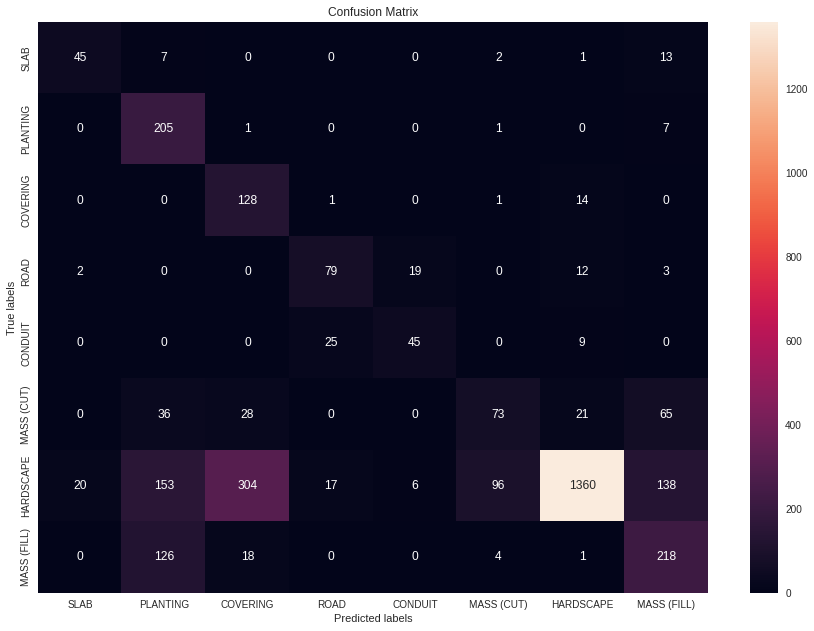

In [ ]:
plt.figure(figsize = (15,10.5))
ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); 
ax.yaxis.set_ticklabels(labels);
